## First lets generate some boards

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import shutil

# generate a random checkerboard pattern image
# user should specify the x and y dimensions of the image, and the size of the checkerboard squares

def generate_checkerboard(x_dim, y_dim, square_size, density=0.5):
    # create an empty image
    img = np.zeros((y_dim, x_dim))

    # determine the number of squares in each direction
    x_squares = x_dim // square_size
    y_squares = y_dim // square_size

    # fill in the image with the checkerboard pattern
    for i in range(x_squares):
        for j in range(y_squares):
            if np.random.rand(1) < density:
                img[j*square_size:(j+1)*square_size, i*square_size:(i+1)*square_size] = 1
    
    return img

def save_image(img, filename):
    img = Image.fromarray((img * 255).astype(np.uint8))
    img.save(filename)


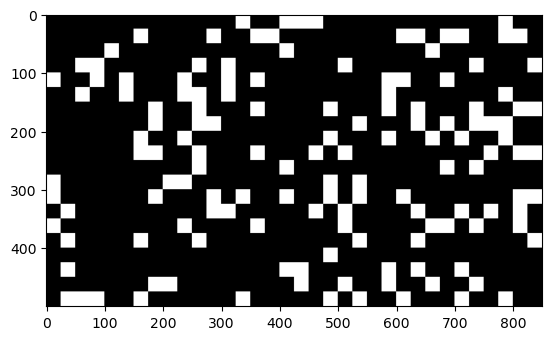

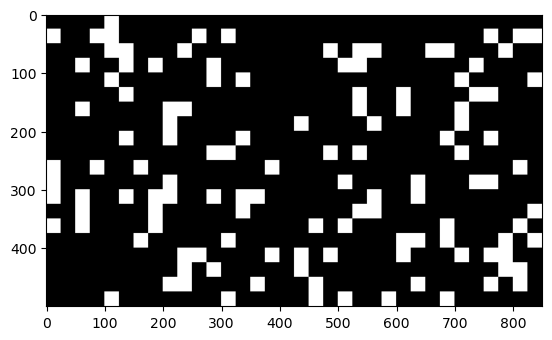

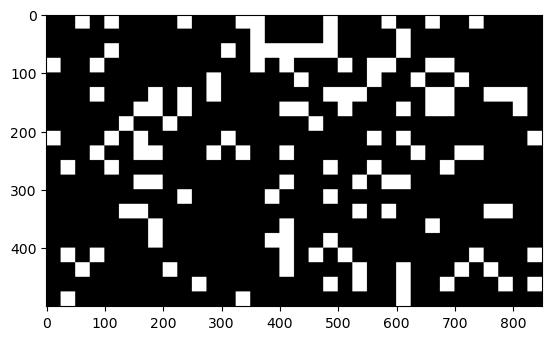

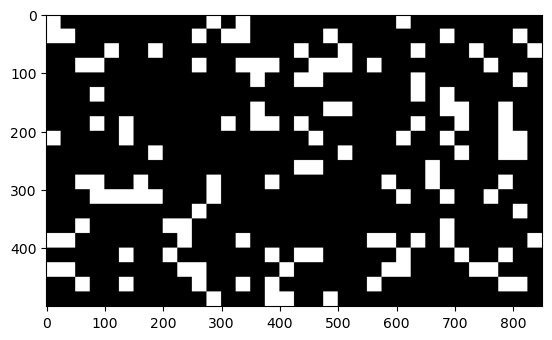

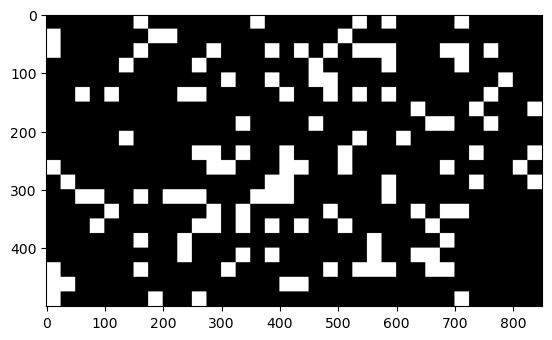

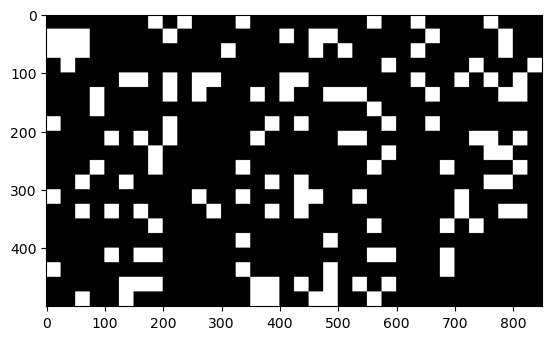

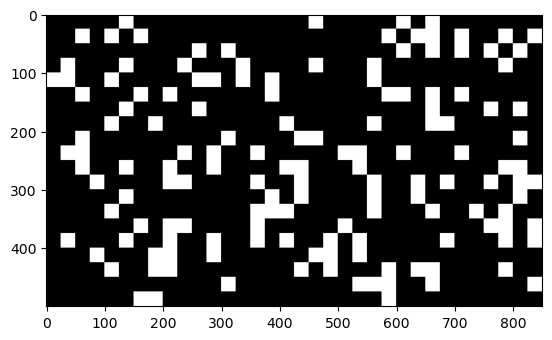

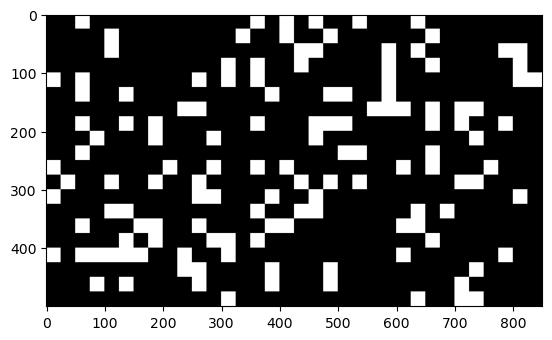

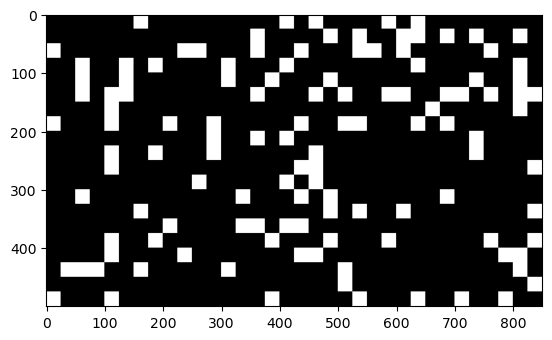

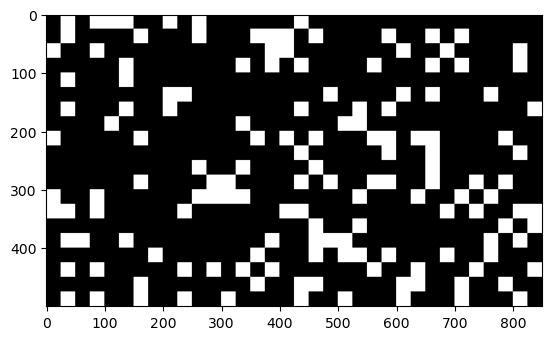

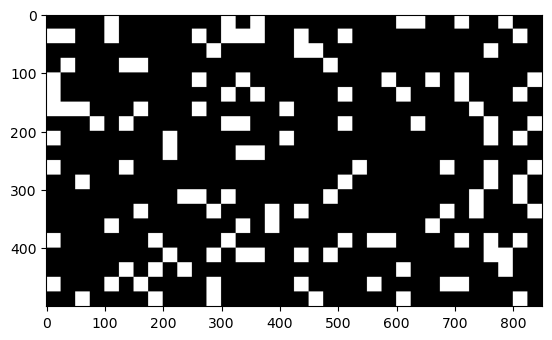

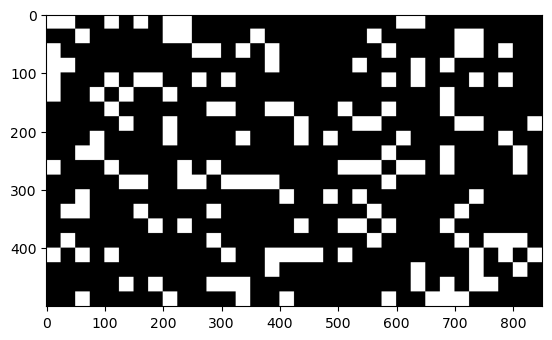

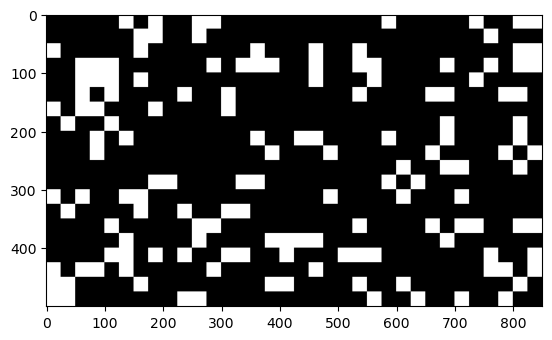

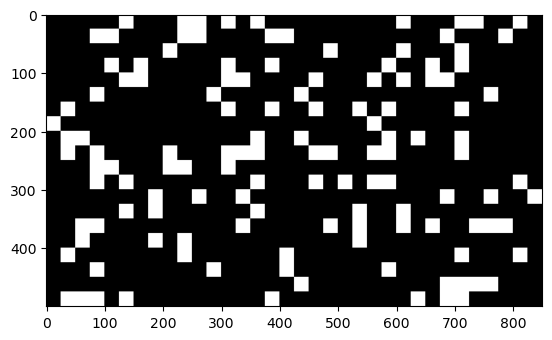

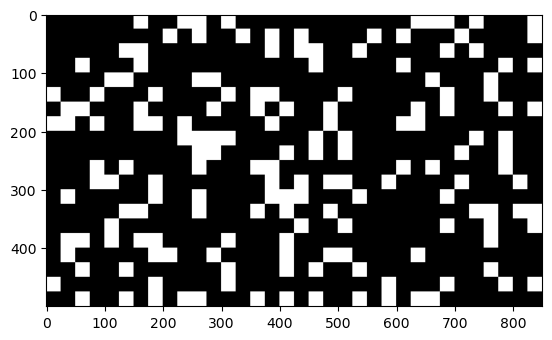

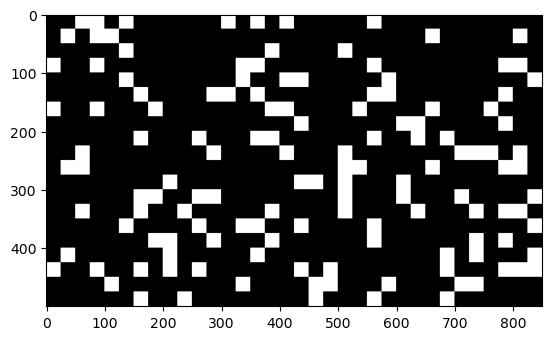

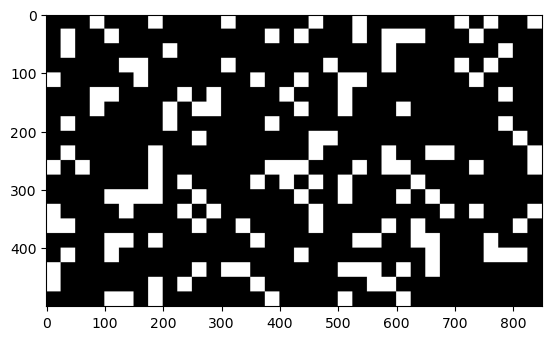

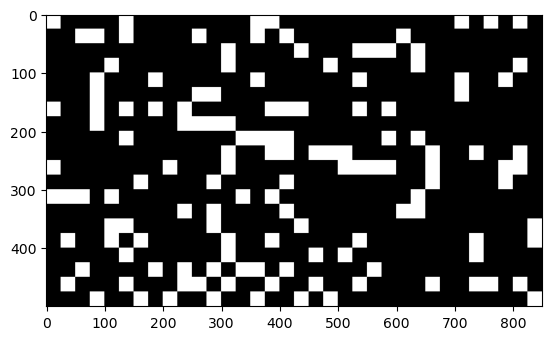

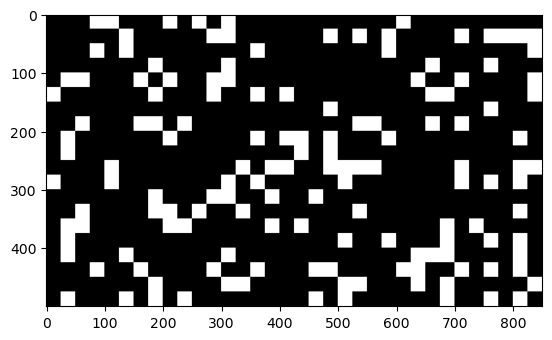

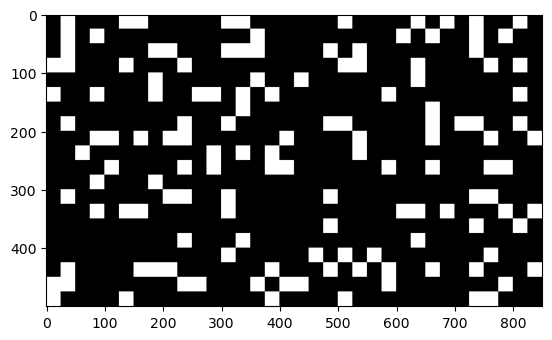

In [7]:
folder_path = 'checkerboards/'
file_name = 'checkerboard'

# Set parameters
x_dim = 850
y_dim = 500
square_size = 25

def generate_multiple_boards(board_number,x_dim,y_dim,square_size):
    for i in range(board_number):
        test = generate_checkerboard(x_dim, y_dim, square_size, density=0.2)
        plt.figure()

        plt.imshow(test, cmap='gray')         
        save_image(test, f'{folder_path}/{file_name}{i}.png')


if os.path.isdir(folder_path):
    shutil.rmtree(folder_path)
os.mkdir(folder_path)   
generate_multiple_boards(20,x_dim,y_dim,square_size)

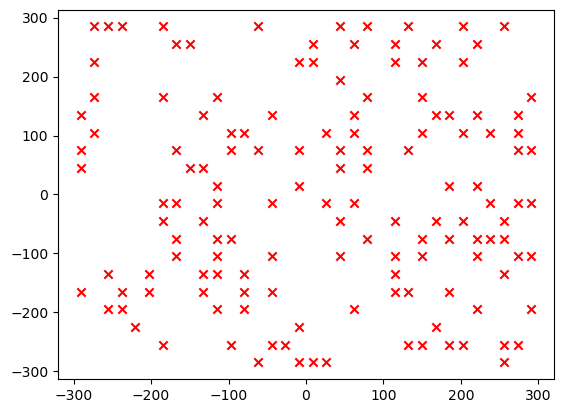

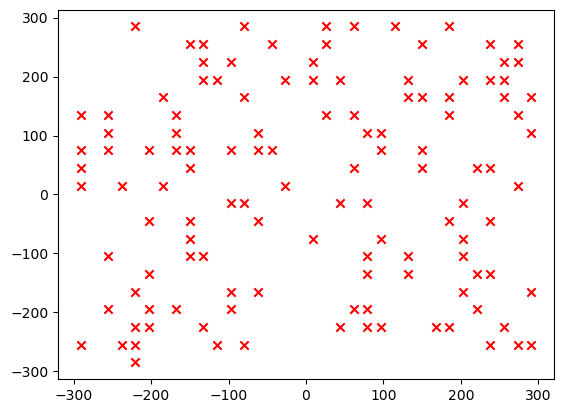

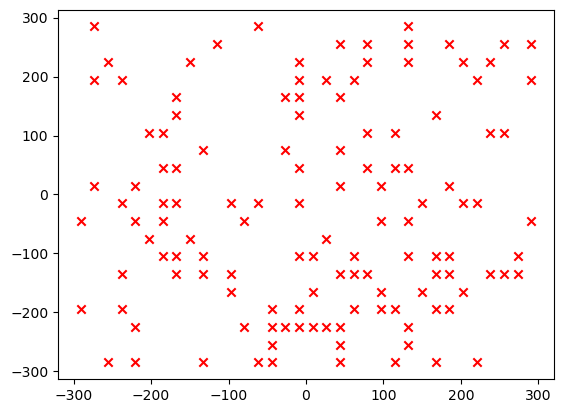

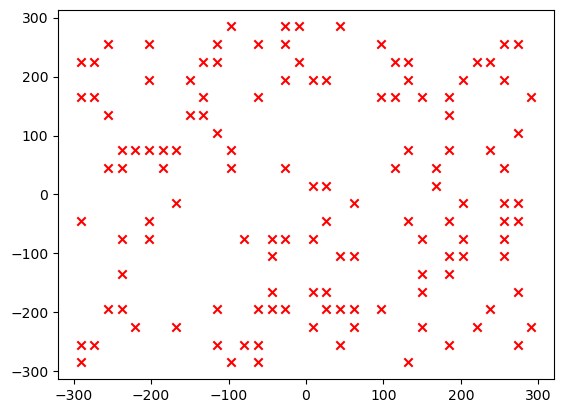

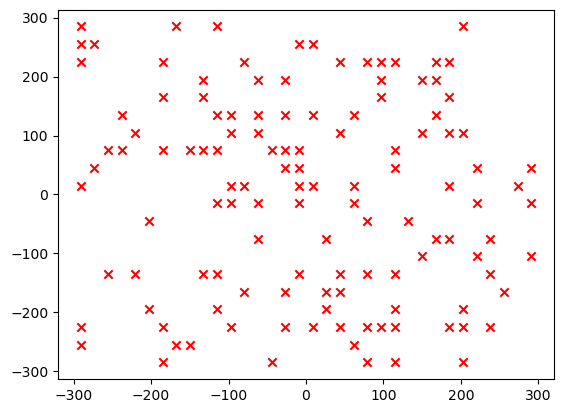

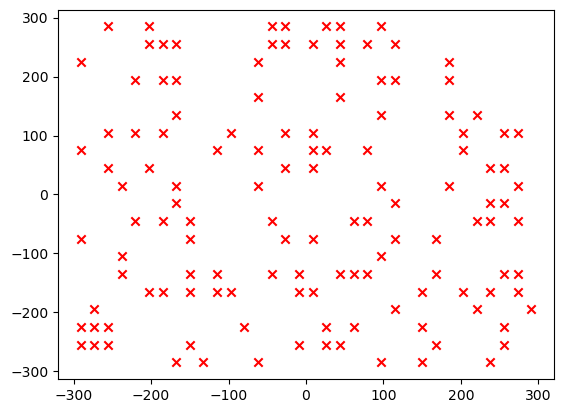

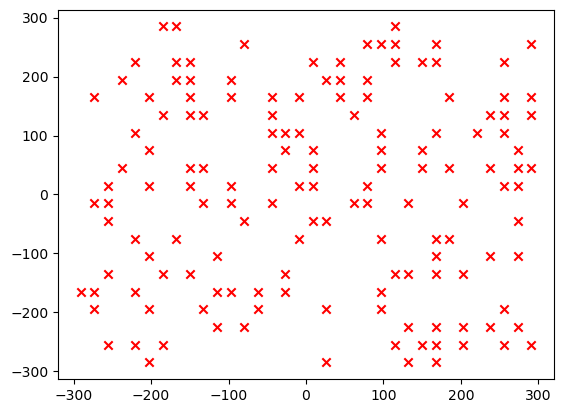

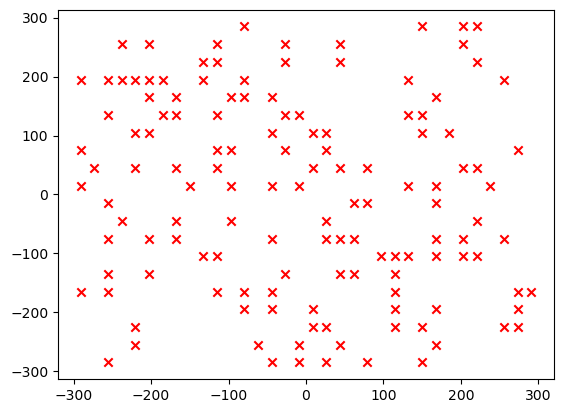

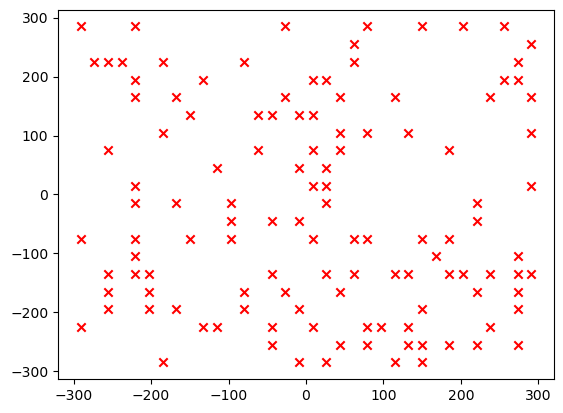

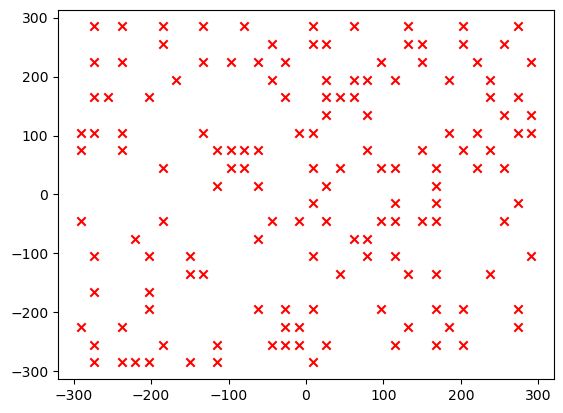

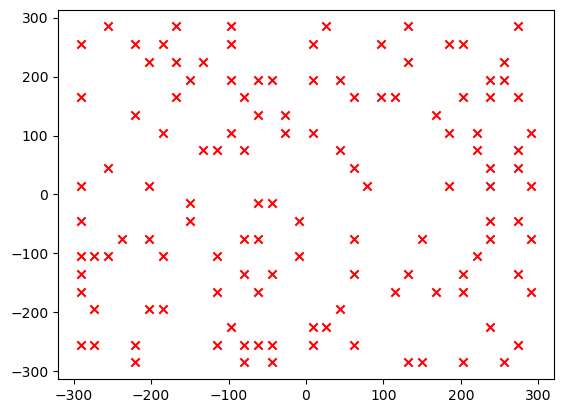

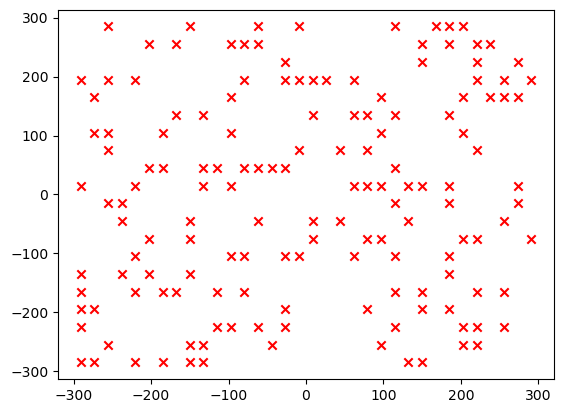

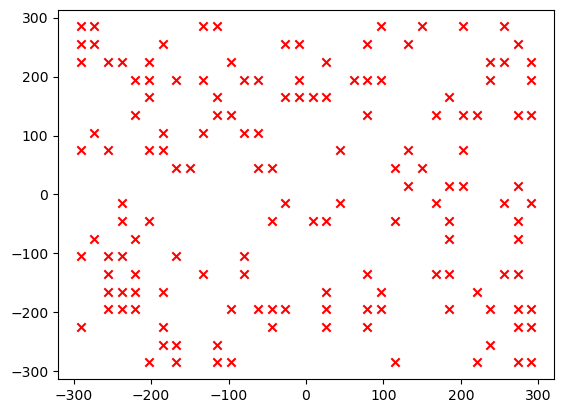

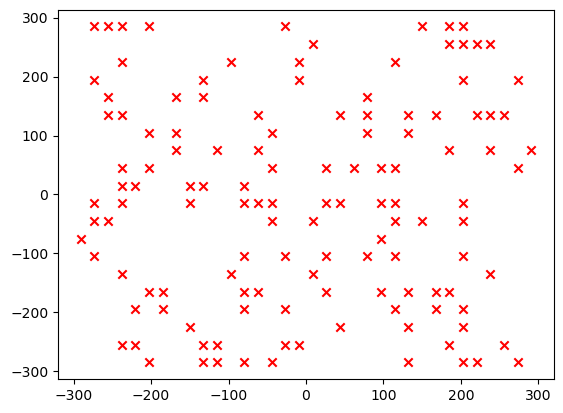

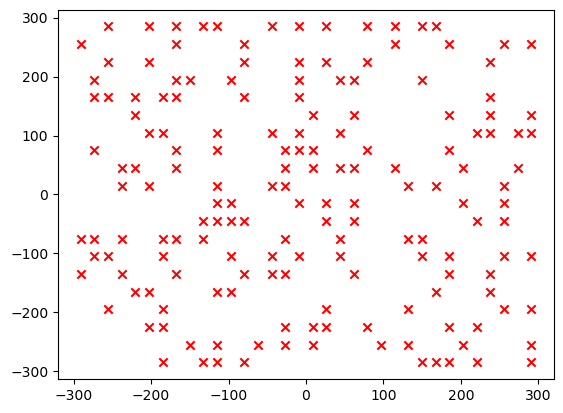

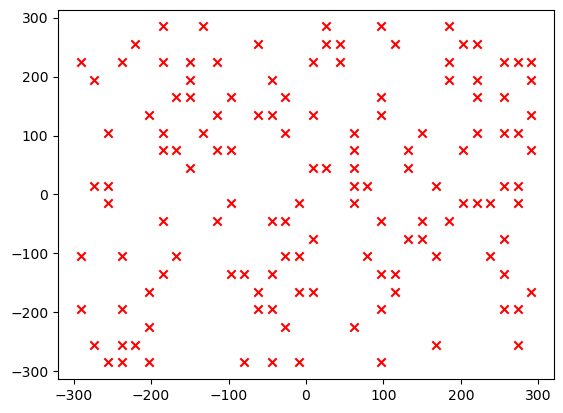

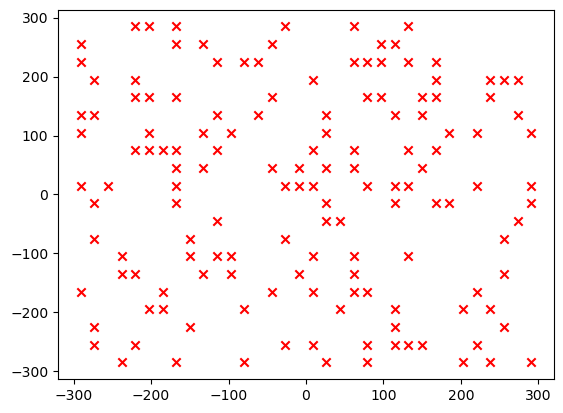

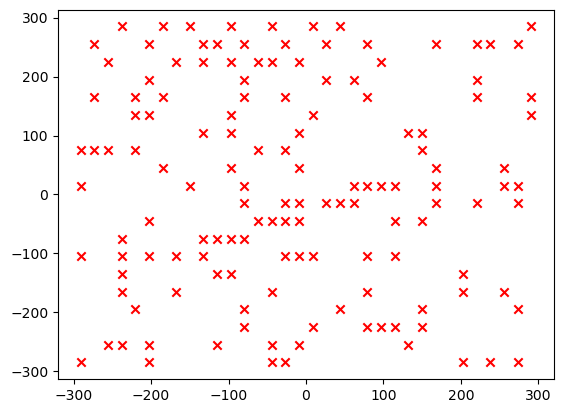

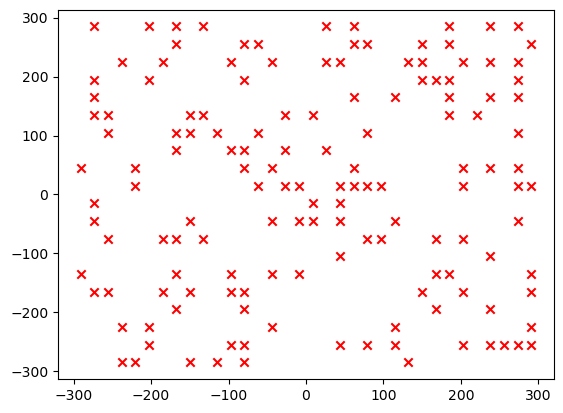

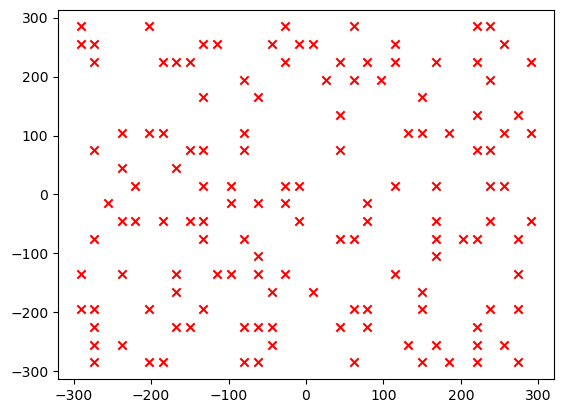

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from PIL import Image
import pandas as pd
import glob

def find_probe_positions(checkerboard_path, x_dim, y_dim, square_size):
    im_frame = Image.open(checkerboard_path)
    np_array = np.array(im_frame)

    # Convert to binary image (assuming white squares are brighter than 128)
    binary_image = np_array > 128

    # Extract positions of individual squares
    square_positions = []
    probe_numbers = []
    x_squares = x_dim // square_size
    y_squares = y_dim // square_size

    # Loop over the grid and record the positions of each square
    square_number = 1
    for j in range(y_squares):  # Loop over rows
        for i in range(x_squares):  # Loop over columns
            # Check if the current square is white
            if np.any(binary_image[j * square_size:(j + 1) * square_size, 
                                   i * square_size:(i + 1) * square_size] == True):
                # Calculate the center position (x, y) of the square
                center_x = i * square_size + square_size / 2
                center_y = j * square_size + square_size / 2
                square_positions.append((center_x, center_y))
                probe_numbers.append(square_number)
            square_number += 1  # Increment square number for all squares

    return binary_image, square_positions, probe_numbers

def scale_to_square(checkerboard_img, square_positions, x_dim, y_dim, target_range=(-300, 300)):
    # Define the target range (from -300 to 300)
    target_width = target_range[1] - target_range[0]
    
    # Calculate scaling factors for both axes
    scale_x = target_width / x_dim
    scale_y = target_width / y_dim
    
    # Calculate new positions
    scaled_square_positions = [
        ((x - x_dim / 2) * scale_x, (y - y_dim / 2) * scale_y)
        for x, y in square_positions
    ]

    # Scale the checkerboard image
    new_checkerboard_img = resize(checkerboard_img, 
                                  (int(checkerboard_img.shape[0] * scale_y), 
                                   int(checkerboard_img.shape[1] * scale_x)),
                                  mode='constant', anti_aliasing=False)

    return new_checkerboard_img, scaled_square_positions

def generate_positions_from_boards(folder_path,x_dim, y_dim, square_size,probe_depth):
    
    files = glob.glob(f"{folder_path}/*.png", recursive=True)
    for index, file in enumerate(files):
        # Find probe positions
        checkerboard, probe_positions, probe_numbers = find_probe_positions(file, x_dim, y_dim, square_size)

        # Scale the checkerboard and probe positions
        scaled_checkerboard, scaled_probe_positions = scale_to_square(checkerboard, probe_positions, x_dim, y_dim)

        # Plot the scaled checkerboard with markers for the square positions
        #plt.imshow(scaled_checkerboard, cmap='gray')
        for pos in scaled_probe_positions:
            plt.scatter(pos[0], pos[1], color='red', marker='x')

        plt.show()

        # Save the positions into a DataFrame
        pos = np.array(scaled_probe_positions)
        pos_tran = pos.T
        depth_of_probe = probe_depth
        df = pd.DataFrame({"probe_number": probe_numbers, "X": pos_tran[0], "Y": pos_tran[1], 'Z': depth_of_probe,"checkerboard_number": index})

        # Save DataFrame to CSV
        df.to_csv(f"{folder_path}/scaled_probe_positions_checkerboard{index}.csv", index=False)


generate_positions_from_boards(folder_path,x_dim,y_dim,square_size,probe_depth=1000)

In [9]:
# check checkerboard and probe locations are alined 



In [10]:
def get_opto_spike_times(df, frequency=100,start=None,end=None):
    probes = df['probe_number']

    # Spike generation
    spike_data = []

    for probe in probes:
        checkerboard_number = df.loc[df['probe_number'] == probe, 'checkerboard_number'].values.astype(int)
        spike_interval = 1000 / frequency  # Interval in ms
        spike_times = np.arange(start, end, spike_interval)  # Generate timestamps
        for timestamp in spike_times:
            spike_data.append((probe, int(checkerboard_number), timestamp))

    # Convert spike data to a DataFrame
    spike_df = pd.DataFrame(spike_data, columns=["probe_number", 'checkerboard_number', "timestamps"])
    return spike_df


def generate_opto_spikes_times(folder_path,start_time = 100, on_time = 2, off_time = 8):
    df_spikes_list = []
    df_probe_positions = []
    
    files = glob.glob(f"{folder_path}/*.csv", recursive=True)

    # Initialize start_time
    start_time = start_time
    
    for file in files:
        checkerboard_probe_positions = pd.read_csv(file)
        
        end_time = start_time + on_time + off_time
        
        spike_df = get_opto_spike_times(checkerboard_probe_positions, start=start_time, end=start_time+on_time)
        df_probe_positions.append(checkerboard_probe_positions)
        df_spikes_list.append(spike_df)
        
        
        # Update start_time for the next file
        start_time = end_time
    
    return df_spikes_list, df_probe_positions


combined_spike_df = pd.DataFrame()
total_probe_locations = pd.DataFrame()

spike_df_list, total_probe_locations_temp = generate_opto_spikes_times(folder_path,on_time=200,off_time=1000)
combined_spike_df = pd.concat([combined_spike_df] + spike_df_list, ignore_index=True)
total_probe_locations = pd.concat([total_probe_locations] + total_probe_locations_temp, ignore_index=True)
combined_spike_df.to_csv("opto_input/combined_checkerboard_spikes_stable.csv",index=False)
total_probe_locations.to_csv("opto_input/combined_probe_positions_stable.csv",index=False)


combined_spike_df = pd.DataFrame()
total_probe_locations = pd.DataFrame()
start_time = 100

for i in range(20):
    spike_df_list, total_probe_locations_iter = generate_opto_spikes_times(folder_path=folder_path, on_time=2, off_time=8, start_time=start_time)

    combined_spike_df = pd.concat([combined_spike_df] + spike_df_list, ignore_index=True)
    total_probe_locations = pd.concat([total_probe_locations] + total_probe_locations_iter, ignore_index=True)

    start_time += 1200

# Save the final concatenated data frames to CSV files
combined_spike_df.to_csv("opto_input/combined_checkerboard_spikes_unstable.csv", index=False)
total_probe_locations.to_csv("opto_input/combined_probe_positions_unstable.csv", index=False)



In [11]:
df_unstable = pd.read_csv("opto_input/combined_checkerboard_spikes_unstable.csv")
df_unstable

,probe_number,checkerboard_number,timestamps
0,14,0,100.0
1,17,0,100.0
2,18,0,100.0
3,19,0,100.0
4,32,0,100.0
...,...,...,...
54795,652,19,23090.0
54796,662,19,23090.0
54797,667,19,23090.0
54798,676,19,23090.0


In [12]:
df_stable = pd.read_csv("opto_input/combined_checkerboard_spikes_stable.csv")
#df_stable = df_stable[df_stable['checkerboard_number'].isin([0, 1])]

In [13]:
df_stable

,probe_number,checkerboard_number,timestamps
0,14,0,100.0
1,14,0,110.0
2,14,0,120.0
3,14,0,130.0
4,14,0,140.0
...,...,...,...
54795,677,19,23050.0
54796,677,19,23060.0
54797,677,19,23070.0
54798,677,19,23080.0


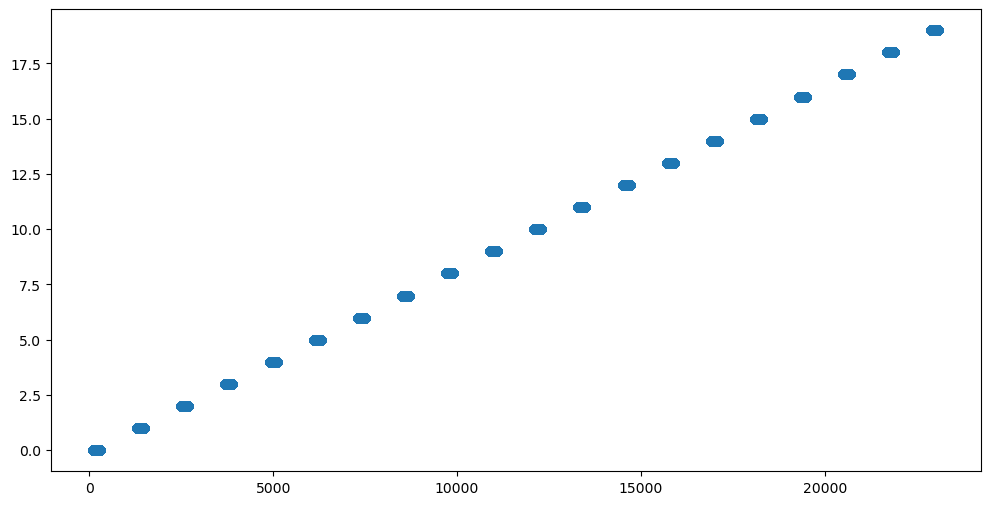

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(df_stable['timestamps'],df_stable['checkerboard_number'])
plt.show()

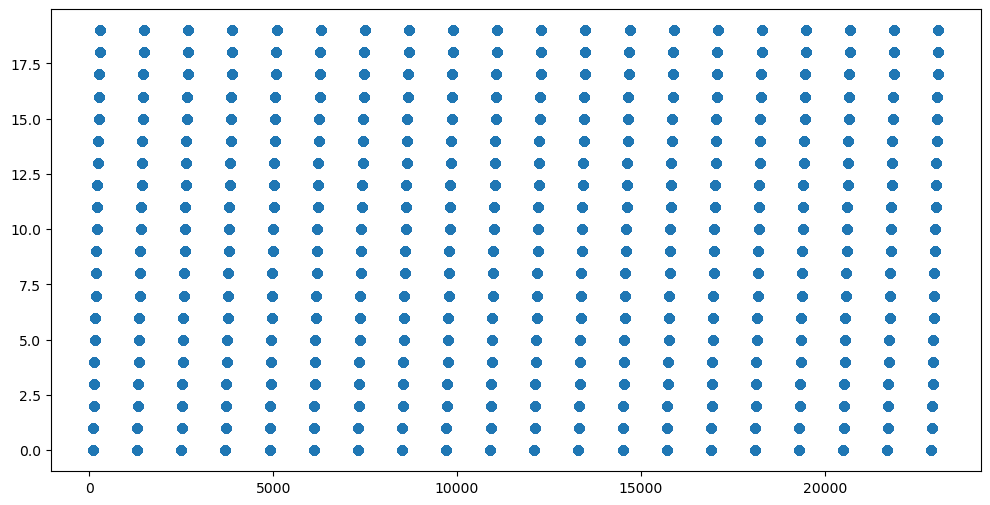

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(df_unstable['timestamps'],df_unstable['checkerboard_number'])
plt.show()

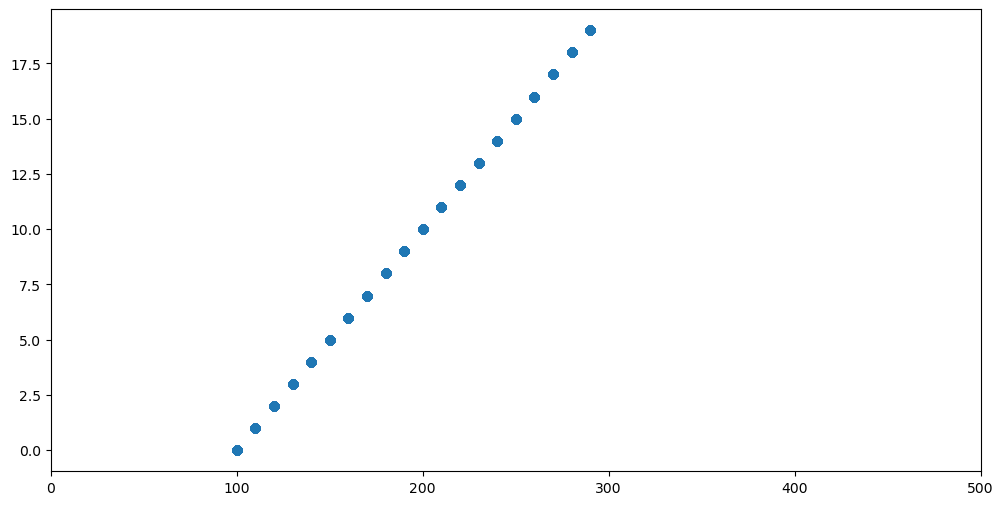

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
plt.scatter(df_unstable['timestamps'],df_unstable['checkerboard_number'])
plt.xlim(0,500)
plt.show()